## Using TF-IDF and assuming each segment as a 'document', where symbols are words.

In [167]:
from __future__ import division
%matplotlib inline
%pylab inline
import csv
import sys
import os
import traceback
import json
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import itertools
import scipy.fftpack as fft
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval
from operator import itemgetter

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [168]:
def find_subsequence(seq, subseq):
    target = np.dot(subseq, subseq)
    candidates = np.where(np.correlate(seq,
                                       subseq, mode='valid') == target)[0]
    # some of the candidates entries may be false positives, double check
    check = candidates[:, np.newaxis] + np.arange(len(subseq))
    mask = np.all((np.take(seq, check) == subseq), axis=-1)
    return candidates[mask]

### Load symbolized segments

In [169]:
mat_dir = "./symbolization_mat"
files = getListOfFiles(mat_dir, ".mat")
print ">> {} mat Files found:\n".format(len(files))
print json.dumps(files)
print
original_files = []
for f in files:
    original_files.append('.'.join(f.split('.')[0:2]))

print ">> {} Original CSV Files:\n".format(len(original_files))
print json.dumps(original_files)

>> 29 mat Files found:

["_2016-11-23-18-49-13_exp1_Player.csv.mat", "_2016-11-23-18-49-13_exp2_Player.csv.mat", "_2016-11-23-18-49-13_exp3_Player.csv.mat", "_2016-11-23-18-49-13_exp4_Player.csv.mat", "_2016-11-23-18-49-13_exp5_Player.csv.mat", "_2016-11-24-15-43-37_exp1d_Player.csv.mat", "_2016-11-24-15-43-37_exp2d_Player.csv.mat", "_2016-11-24-15-43-37_exp4d_Player.csv.mat", "_2016-11-24-15-43-37_exp5d_Player.csv.mat", "_2016-11-24-15-43-37_exp6d_Player.csv.mat", "_2016-11-24-16-23-29_expa_Player.csv.mat", "_2016-11-24-16-23-29_expb_Player.csv.mat", "_2016-11-24-16-23-29_expc_Player.csv.mat", "_2016-11-24-16-23-29_expd_Player.csv.mat", "_2016-11-24-16-48-48_exp1d_Player.csv.mat", "_2016-11-24-16-48-48_exp3d_Player.csv.mat", "_2016-11-24-17-15-38_expa_Player.csv.mat", "_2016-11-24-17-15-38_expb_Player.csv.mat", "_2016-11-24-17-15-38_expc_Player.csv.mat", "_2016-11-24-17-40-06_expb_Player.csv.mat", "_2016-11-26-16-05-47_exp1d_Player.csv.mat", "_2016-11-26-16-35-21_exp1d_Player.csv.mat"

In [170]:
sym_segments = []
sym_file_map = []
count = 0
min_length = float('inf')
for f in files:
    mat_content = sio.loadmat(os.path.join(mat_dir, f))
    #print mat_content
    data = mat_content['c_sym']
    #print data.tolist()[0]
    for d in data.tolist()[0]:
        if d[0].size == 0:
            pass
        else:
            count += 1
            sample = [str(i[0]) for i in d.tolist()]
            if len(sample) < min_length:
                min_length = len(sample)
            sample = ' '.join(map(str, sample)) # separate caracters by space
            sym_segments.append(sample)
            sym_file_map.append('.'.join(f.split('.')[0:2]))
            

assert (len(sym_segments) == count)
print 'N. of segments {}'.format(count)
print 'Min. sample size of {}'.format(min_length)

N. of segments 643
Min. sample size of 50


## Load original recomposed signal

In [171]:
mat_dir = "./mat_jerk_files"
original_files = getListOfFiles(mat_dir, ".mat")
print ">> {} mat Files found:\n".format(len(files))
original = {}
for f in original_files:
    mat_content = sio.loadmat(os.path.join(mat_dir, f))
    original[f] = mat_content['vect'].tolist()[0]

print '>> N. recovered signals {}'.format(len(original))

>> 29 mat Files found:

>> N. recovered signals 29


## Load signal segments files

In [172]:
mat_dir = "./segments"
signal_files = getListOfFiles(mat_dir, ".mat")
print ">> {} mat Files found:\n".format(len(files))
print json.dumps(files)
print
original_files = []
for f in files:
    original_files.append('.'.join(f.split('.')[0:2]))

>> 29 mat Files found:

["_2016-11-23-18-49-13_exp1_Player.csv.mat", "_2016-11-23-18-49-13_exp2_Player.csv.mat", "_2016-11-23-18-49-13_exp3_Player.csv.mat", "_2016-11-23-18-49-13_exp4_Player.csv.mat", "_2016-11-23-18-49-13_exp5_Player.csv.mat", "_2016-11-24-15-43-37_exp1d_Player.csv.mat", "_2016-11-24-15-43-37_exp2d_Player.csv.mat", "_2016-11-24-15-43-37_exp4d_Player.csv.mat", "_2016-11-24-15-43-37_exp5d_Player.csv.mat", "_2016-11-24-15-43-37_exp6d_Player.csv.mat", "_2016-11-24-16-23-29_expa_Player.csv.mat", "_2016-11-24-16-23-29_expb_Player.csv.mat", "_2016-11-24-16-23-29_expc_Player.csv.mat", "_2016-11-24-16-23-29_expd_Player.csv.mat", "_2016-11-24-16-48-48_exp1d_Player.csv.mat", "_2016-11-24-16-48-48_exp3d_Player.csv.mat", "_2016-11-24-17-15-38_expa_Player.csv.mat", "_2016-11-24-17-15-38_expb_Player.csv.mat", "_2016-11-24-17-15-38_expc_Player.csv.mat", "_2016-11-24-17-40-06_expb_Player.csv.mat", "_2016-11-26-16-05-47_exp1d_Player.csv.mat", "_2016-11-26-16-35-21_exp1d_Player.csv.mat"

## Realign segments

In [173]:
sig_segments = []
sig_file_map = []
succ_alignments = []
min_length = float('inf')
for f in files:
    mat_content = sio.loadmat(os.path.join(mat_dir, f))
    data = mat_content['C']
    data = data.tolist()[0]
    file_segments = []
    for d in data:
        if d[0].size == 0:
            pass
        else:
            sample = [i[0] for i in d.tolist()]
            file_segments.append(sample)
            if len(sample) < min_length:
                min_length = len(sample)
    
    ### aligning ###
    alignment = []
    for i,s in enumerate(file_segments):
        alignment.append((i,find_subsequence(original[f],s)[0]))
    print alignment
    seq_align_indexes = [x[1] for x in alignment]
    print seq_align_indexes
    alignment.sort(key=lambda tup: tup[1])
    print 
    print alignment
    ### testing the realignment ###
    print '-- Checking alignment for sequence...'
    restored = [] 
    for l,i in alignment:
        restored += file_segments[l]
    try:
        assert original[f] == restored
        print '$$ Segments ALIGNED!'
    except AssertionError:
        print '%%%%% File {} FAILED to assert equality for aligned sequence %%%%%'.format(f)
        break
    
    ### saving ###
    for s in range(len(file_segments)):
        sig_segments.append(file_segments[s])
        sig_file_map.append('.'.join(f.split('.')[0:2]))
        succ_alignments.append(seq_align_indexes[s])
   
    assert len(sig_segments) == len(sig_file_map) == len(succ_alignments)
print 'Files list number: {}'.format(len(sig_segments))
print 'Min. sample size of {}'.format(min_length)

[(0, 266), (1, 614), (2, 721), (3, 1458), (4, 983), (5, 120), (6, 190), (7, 866), (8, 926), (9, 0), (10, 66), (11, 1054), (12, 1146), (13, 1390), (14, 1208), (15, 1281), (16, 1336), (17, 1666), (18, 1748)]
[266, 614, 721, 1458, 983, 120, 190, 866, 926, 0, 66, 1054, 1146, 1390, 1208, 1281, 1336, 1666, 1748]

[(9, 0), (10, 66), (5, 120), (6, 190), (0, 266), (1, 614), (2, 721), (7, 866), (8, 926), (4, 983), (11, 1054), (12, 1146), (14, 1208), (15, 1281), (16, 1336), (13, 1390), (3, 1458), (17, 1666), (18, 1748)]
-- Checking alignment for sequence...
$$ Segments ALIGNED!
[(0, 1183), (1, 708), (2, 1622), (3, 1971), (4, 2032), (5, 225), (6, 285), (7, 113), (8, 170), (9, 0), (10, 59), (11, 1235), (12, 1307), (13, 1540), (14, 366), (15, 444), (16, 1366), (17, 1427), (18, 657), (19, 540), (20, 593), (21, 798), (22, 897)]
[1183, 708, 1622, 1971, 2032, 225, 285, 113, 170, 0, 59, 1235, 1307, 1540, 366, 444, 1366, 1427, 657, 540, 593, 798, 897]

[(9, 0), (10, 59), (7, 113), (8, 170), (5, 225), (6, 

## Vectorize 'documents'

In [174]:
### Create Vocabulary ####
n_clusters = 20    # Number of clusters used in the symbolization process
voc = {}
for c in range(n_clusters): 
    voc[str(c+1)] = c  ## Remember, the vocabulary construction begins with 1 (MATLAB clustering/vector), not 0. 

##### Create the term-frequency analyser. ####
#vectorizer = CountVectorizer(lowercase=False, token_pattern='\s(\w+)\s', vocabulary=voc)
#print vectorizer
# Let’s use the vectorizer now to create the sparse
# matrix of our segments (documents)
#smatrix = vectorizer.transform(sym_segments)
# Note that the sparse matrix created called smatrix is a 
# Scipy sparse matrix with elements stored in a Coordinate format. 
# But you can convert it into a dense format:
#print smatrix.todense()

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(lowercase=False, token_pattern='\s(\w+)\s', vocabulary=voc)
%time tfidf_matrix = tfidf_vectorizer.fit_transform(sym_segments)
print tfidf_vectorizer
print 'Documents in VSM:'
print tfidf_matrix.todense()
print 'Document matrix shape:'
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

## Distance measure
dist = 1 - cosine_similarity(tfidf_matrix)

CPU times: user 42.9 ms, sys: 16.9 ms, total: 59.8 ms
Wall time: 49.6 ms
TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='\\s(\\w+)\\s', tokenizer=None, use_idf=True,
        vocabulary={'11': 10, '10': 9, '13': 12, '12': 11, '15': 14, '14': 13, '17': 16, '16': 15, '19': 18, '18': 17, '20': 19, '1': 0, '3': 2, '2': 1, '5': 4, '4': 3, '7': 6, '6': 5, '9': 8, '8': 7})
Documents in VSM:
[[ 0.          0.04053568  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.19733421 ...,  0.          0.          0.        ]
 [ 0.          0.23315212  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ..

## Clustering

In [176]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
cluster_centers = km.cluster_centers_
print 'Cluster centers:'
print cluster_centers

CPU times: user 535 ms, sys: 5.23 ms, total: 541 ms
Wall time: 542 ms
Cluster centers:
[[ 0.04998017  0.06693512  0.06316076  0.19410335  0.05874019  0.15694106
   0.13729327  0.09090971  0.05681595  0.03350128  0.11609981  0.18169727
   0.05568705  0.13603216  0.10820494  0.1978623   0.06383005  0.17041725
   0.10029336  0.18498186]
 [ 0.82526495  0.01627085  0.05525343  0.0115289   0.04248464  0.03881295
   0.01881157  0.02245039  0.04951235  0.03132161  0.04264148  0.03352561
   0.06104453  0.02519687  0.06520297  0.01874153  0.04949401  0.055637
   0.08976804  0.04838712]
 [ 0.06864548  0.05395855  0.75948151  0.05307777  0.03652055  0.06231662
   0.04065805  0.03056777  0.01887982  0.03261362  0.0807065   0.07534666
   0.0273731   0.05022803  0.0428671   0.08015985  0.0357958   0.11271637
   0.06426185  0.0248217 ]
 [ 0.01261811  0.80025168  0.01556201  0.04396612  0.01546992  0.11693414
   0.04819091  0.00863149  0.01664342  0.02209143  0.07051819  0.00708849
   0.06050657  0.032

### Pickle the model

In [177]:
joblib.dump(km, os.path.join(mat_dir,'kmean_cluster.pkl'))    ## save to file
#km = joblib.load('doc_cluster.pkl')    ## load from file

['./segments/kmean_cluster.pkl']

### Framing corpus

In [178]:
clusters = km.labels_.tolist()
ranks = [i for i in range(len(sym_segments))]

df = {'sym_segments':sym_segments,
      'cluster':clusters,
      'rank':ranks,
      'sig_segments':sig_segments,
      'sig_file_map':sig_file_map,
      'sym_file_map':sym_file_map,
      'alignment': succ_alignments
     }

frame = pd.DataFrame(df, index = [clusters] , columns = ['sym_segments','cluster','rank','sig_segments',
                                                         'sig_file_map','sym_file_map', 'alignment'])
assert frame['sig_file_map'].equals(frame['sym_file_map'])
print 'Cluster counts: '
frame['cluster'].value_counts()

Cluster counts: 


0    232
4    191
1     88
2     71
3     61
Name: cluster, dtype: int64

In [179]:
grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

cluster
0    346.715517
1    337.829545
2    273.281690
3    308.393443
4    303.774869
Name: rank, dtype: float64

In [180]:
vocab_frame = pd.DataFrame({'words': tfidf_vectorizer.vocabulary})#, index = totalvocab_stemmed)

print "Top terms per cluster:"
print
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print "Cluster %d words:" % i,
    for ind in order_centroids[i, :6]:
        print ' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0],
    print
    print
    print "Cluster %d segments:" % i,
    for title in frame.ix[i]['sym_segments'].values.tolist():
        print ' %s,' % title,
    print
    print

Top terms per cluster:

Cluster 0 words:  15  3  19  11  17  5

Cluster 0 segments:  3 3 3 3 3 3 3 3 3 3 3 13 13 11 12 12 14 14 14 14 14 14 14 14 14 14 13 13 13 13 12 12 14 14 14 14 14 14 14 14 14 14 14 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 4 14 14 4 4 4 4 4 4 4 4 4 4 8 8 8 8 8 8 8 8 8 8 6 6 6 6 6 6 6 6 6 6 6 17 6 6 17 17 15 15,  8 8 8 8 8 8 8 8 13 13 13 13 13 13 13 1 1 1 1 1 1 19 19 19 19 19 19 19 19 20 20 20 20 20 20 9 9 9 9 7 7 7 18 18 18 18 4 18 4 4 4 4 4 4 12 12 12 4 4 8 8 8 8 8 8 8 8 8 8 8,  18 18 18 18 18 18 18 12 12 12 12 12 4 4 4 4 4 4 4 4 4 4 4 11 5 5 5 5 5 5 5 5 14 14 14 14 14 14 14 6 6 6 6 6 6 20 8 8 8 20 20 20,  4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 8 16 16 16 16 16 5 14 14 14 14 8 8 8 8 6 17 17 17 6 6 6 6 6 6 14 14 14 14 3 3 3 3 3 3 3 3 20 3 20 20 20 20 20 3 15 15 15 15 15 15 15 15 15 15 15 15 18 18 18 18 18 18 18 18 18,  15 15 15 15 15 15 4 4 4 4 4 4 12 12 12 12 12 12 12 15 15 15 15 15 15 18 18 18 18 18 18 18 18 18 18 18 18 18 18 

## Multidimensional scaling

In [181]:
from sklearn.manifold import MDS

MDS()
# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

## Visualizing document clusters

In [182]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4', 
                 4: 'Cluster 5'}

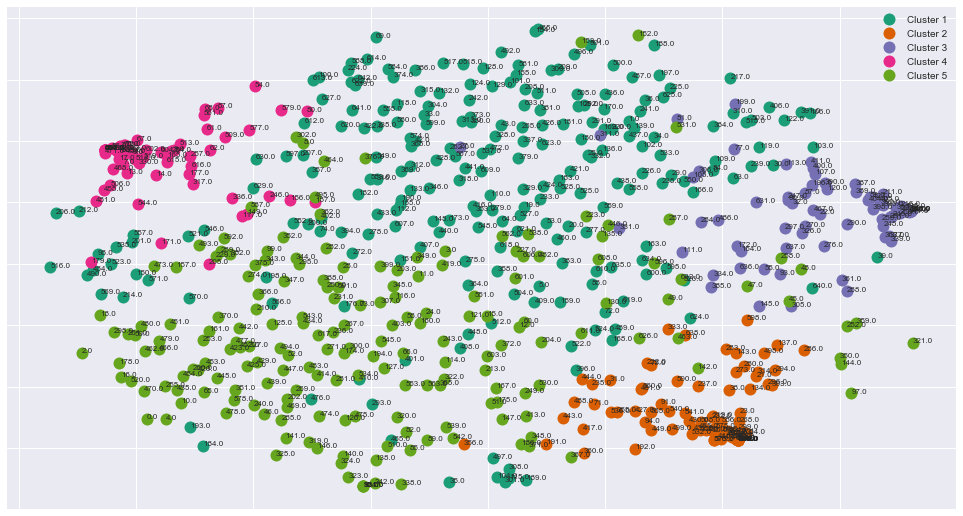

In [183]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(len(sym_segments)))) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

## Save to pickle

In [184]:
# open the file for writing
file_name = 'cluster_info_matrix.pkl'
file_object = open(file_name,'wb')
pickle.dump(frame,file_object)
file_object.close()
print 'pickle DONE!'

pickle DONE!


## Cluster's members

In [ ]:
grid_side_size = 5
fig, axes = plt.subplots(4, grid_side_size, figsize=(20,9))

first_50 = defaultdict(list)
for ind,c in enumerate(clusters):
    axes[0][c].plot(sig_segments[ind])
    axes[0][c].set_title('Cluster {}'.format(c))
    first_50[c].append(sig_segments[ind][:50])
    
for c,l in first_50.iteritems():
    sig = np.matrix(l)
    mean_of_sig = np.mean(sig,axis=0).tolist()[0]
    std_of_sig  = np.std(sig,axis=0).tolist()[0]
    axes[1][c].errorbar(range(len(mean_of_sig)),mean_of_sig,yerr=std_of_sig, fmt='-o', ecolor='r')
    axes[1][c].set_title('Mean of first 50 pts - Cluster {}'.format(c))
    axes[1][c].plot(mean_of_sig, c='m')
    
N_fft = 100 # FFT number of bins
Fs = 100 # Frequence range we are interested

for c,l in first_50.iteritems():
    # getting the signal (the mean value of each 50-length segment in the cluster). Assumed to be the
    # mean of the cluster.
    sig = np.mean(np.matrix(l),axis=0).tolist()[0]
    mean_sig = np.ones_like(sig)*np.mean(sig)
    # remove mean of the signal, for better results.
    sig = sig - mean_sig
    ### FFT
    freqsig = fft.fft(sig, n=N_fft)
    freq_axis = np.arange(0, Fs, Fs / N_fft)
    axes[2][c].plot(freq_axis, np.abs(freqsig), lw=2.0, c='b')
    p = plt.Rectangle((Fs/2, 0), Fs/2, ax.get_ylim()[1], facecolor="grey", fill=True, alpha=0.75, hatch="/", zorder=3)
    axes[2][c].add_patch(p)
    axes[2][c].set_xlim((-2,Fs))
    axes[2][c].set_xlim((-2,Fs))
    axes[2][c].set_title("FFT - Cluster{}".format(c), fontsize=10)
    axes[2][c].set_ylabel('Power')
    axes[2][c].set_xlabel('Frequency (Hz)')
    axes[2][c].legend((p,), ('excluded',))
    axes[2][c].grid()

for cc in range(len(cluster_centers)):
    axes[3][cc].plot(cluster_centers[cc])
    axes[3][cc].set_title('Centroid of cluster {}'.format(cc))
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.8, wspace=0.5)
plt.draw()

## Hierarchical document clustering

Now that I was successfuly able to cluster and plot the documents using k-means, I wanted to try another clustering algorithm. I chose the [Ward clustering algorithm](http://en.wikipedia.org/wiki/Ward%27s_method) because it offers hierarchical clustering. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. I used the precomputed cosine distance matrix (*dist*) to calculate a linkage_matrix, which I then plot as a dendrogram. 

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(12, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=range(len(segments)))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## T-sne

In [ ]:
%%time

from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

ncomps = 10
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(smatrix.todense())
Y = svd.fit_transform(smatrix.todense()) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3)).set_ylim([0,1.1])
print('Variance preserved by first 50 components == {:.2%}'.format(
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [ ]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=frame.index)
print(dfsvd.shape)
dfsvd.head()

In [ ]:
plotdims = 5
ploteorows = 1
svdcols = [c for c in dfsvd.columns if c[0] == 'c']
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['cluster'] = frame['cluster']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='cluster', size=2.5)


In [ ]:
Z = TSNE().fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})

In [ ]:
dftsne['cluster'] = frame['cluster']
g = sns.lmplot('x', 'y', dftsne, hue='cluster', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 20D dataset reduced to 2D using t-SNE')

## With DBSCAN

In [ ]:
from sklearn.cluster import dbscan
db_a = dbscan(tfidf_matrix,eps=0.60, min_samples=3)
clusters = db_a[1].tolist()
ranks = [i for i in range(len(segments))]
ndf = {'indexes' : range(len(segments)), 'segments': segments,'cluster': clusters, 'rank': ranks}
nframe = pd.DataFrame(ndf, index = [clusters] , columns = ['indexes','segments','cluster','rank'])
nframe['cluster'].value_counts()

In [ ]:
ncomps = 10
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(smatrix.todense())
Y = svd.fit_transform(smatrix.todense()) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3)).set_ylim([0,1.1])
print('Variance preserved by first 50 components == {:.2%}'.format(
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [ ]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=nframe.index)
print(dfsvd.shape)
dfsvd.head()

In [ ]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['cluster'] = nframe['cluster']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='cluster', size=2.5)

In [ ]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']
Z = TSNE().fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})

In [ ]:
dftsne['cluster'] = nframe['cluster']
g = sns.lmplot('x', 'y', dftsne, hue='cluster', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 20D dataset reduced to 2D using t-SNE')